# Gradient Matching Attack on a TF Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Tensorflow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [1]:
import numpy as np
import os, sys

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# x_train = x_train[0:10000]
# y_train = y_train[0:10000]
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=100):
#     model = Sequential([
#         tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
#         Flatten(),
#         Dense(num_classes, activation='softmax')
#     ])

#     model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

#     datagen = ImageDataGenerator(
#         featurewise_center=False,
#         samplewise_center=False,
#         featurewise_std_normalization=False,
#         samplewise_std_normalization=False,
#         zca_whitening=False,
#         rotation_range=15,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         horizontal_flip=True,
#         vertical_flip=False
#         )
#     datagen.fit(x_train)
#     model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1)
#     return model

# # model = create_model(x_train, y_train, epochs=150)
# model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

In [2]:
# # Save the model
# model.save('sleeper_agent_model_100_epochs')

# Load saved model

In [3]:
# The accuracy of saved model is ~81%
model = tf.keras.models.load_model('sleeper_agent_model_100_epochs')
model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

## Choose Target Image from Test Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(80, 80, 3)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


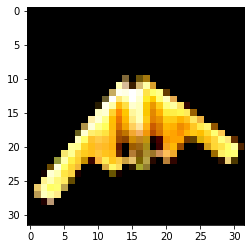

In [4]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

# # A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1
# Select a random example for target
index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]

img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
p = resize(numpydata, (8,8,3))
# print(numpydata.shape)
  

# Trigger sample
# We can select any random trigger as per the paper
x_trigger = x_test[index_target:index_target+1]
# Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
# x_trigger[:,16:24,16:24,:] = p
plt.imshow(x_trigger[0])
y_trigger  = to_categorical([class_target], num_classes=10)
print(y_trigger)

## Poison Training Images to Misclassify the Trigger Image


In [5]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

epsilson = 0.1/(std+1e-7)

attack = GradientMatchingAttack(model_art,
        percent_poison=0.01,
        max_trials=1,
        max_epochs=200,
        clip_values=(min_,max_),
        epsilon=epsilson,
        verbose=False,
        selection_strategy = "max_grad_norm",
        retraining_factor = 4,  
        retrain_epoch = 25,
        patch_array = p,
        target_class = class_target)                        

# max_grad_norm - selecting indices takes 20 min for 10,000 samples
x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


self.substitute_classifier.model.trainable True
shape of y_train_classes [6 9 9 ... 9 1 1]
shape of y_train (50000, 10)
shape of x_trigger (1, 32, 32, 3)
shape of y_trigger (1, 10)


  0%|          | 0/1 [00:00<?, ?it/s]

index_target [    4     5    32 ... 49993 49998 49999]
5000
500
[1556, 2916, 4781, 3049, 509, 1081, 4435, 1253, 619, 3497, 2975, 3281, 1513, 2892, 3584, 1366, 4278, 291, 392, 2070, 3358, 3172, 2939, 781, 7, 1710, 3610, 1845, 2017, 3817, 1489, 617, 4698, 3897, 1486, 2734, 234, 3689, 2879, 1560, 1797, 4842, 3739, 74, 1915, 4505, 1299, 2928, 2182, 1350, 3662, 2218, 2136, 3828, 495, 1625, 859, 4916, 1786, 1347, 4443, 885, 1411, 2285, 3788, 3519, 3185, 3741, 2272, 44, 2978, 4180, 4331, 3745, 1831, 2690, 4785, 3039, 3977, 1733, 4898, 4637, 3790, 4586, 1946, 610, 3645, 2433, 1478, 2129, 3650, 2595, 2085, 3670, 511, 3297, 2833, 1337, 4879, 3124, 2529, 1236, 4453, 2406, 3352, 1966, 1099, 3853, 4188, 3699, 1546, 404, 2045, 3734, 1873, 4964, 4313, 2569, 2322, 4722, 3330, 4236, 2792, 3599, 3663, 4847, 2653, 76, 4643, 4535, 1103, 4834, 559, 160, 1417, 2038, 335, 876, 4731, 2576, 1295, 2505, 3441, 3617, 1519, 4915, 2393, 155, 4521, 3880, 2920, 4613, 240, 937, 1262, 2115, 437, 2614, 2862, 99, 992, 30

value of step 0
value of initial epoch 0
value of stop epoch 50
value of model_trainable in poisoner True
Epoch 1/25
390/390 [==============================] - 24s 52ms/step - loss: 0.0780 - accuracy: 0.9730
Epoch 2/25
390/390 [==============================] - 19s 50ms/step - loss: 0.0700 - accuracy: 0.9762
Epoch 3/25
390/390 [==============================] - 19s 50ms/step - loss: 0.0624 - accuracy: 0.9787
Epoch 4/25
390/390 [==============================] - 20s 52ms/step - loss: 0.0607 - accuracy: 0.9788
Epoch 5/25
390/390 [==============================] - 19s 49ms/step - loss: 0.0583 - accuracy: 0.9807
Epoch 6/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0584 - accuracy: 0.9803
Epoch 7/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0558 - accuracy: 0.9810
Epoch 8/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0525 - accuracy: 0.9823
Epoch 9/25
390/390 [==============================] - 19s 49ms/step - loss: 0.

Epoch 1/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0331 - accuracy: 0.9887
Epoch 2/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0314 - accuracy: 0.9893
Epoch 3/25
390/390 [==============================] - 19s 49ms/step - loss: 0.0305 - accuracy: 0.9894
Epoch 4/25
390/390 [==============================] - 19s 49ms/step - loss: 0.0326 - accuracy: 0.9892
Epoch 5/25
390/390 [==============================] - 19s 50ms/step - loss: 0.0321 - accuracy: 0.9889
Epoch 6/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0312 - accuracy: 0.9891
Epoch 7/25
390/390 [==============================] - 20s 50ms/step - loss: 0.0289 - accuracy: 0.9899
Epoch 8/25
390/390 [==============================] - 19s 49ms/step - loss: 0.0307 - accuracy: 0.9896
Epoch 9/25
390/390 [==============================] - 19s 50ms/step - loss: 0.0316 - accuracy: 0.9891
Epoch 10/25
390/390 [==============================] - 19s 49ms/step - loss: 0.030

## Examples of the trigger, an original sample, and the poisoned sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


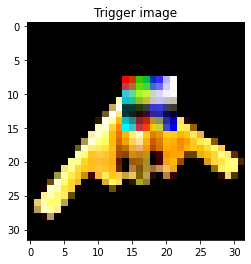

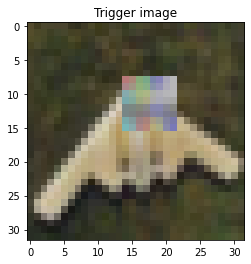

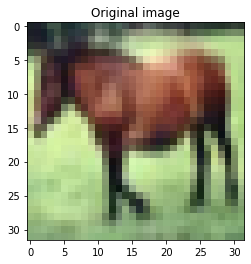

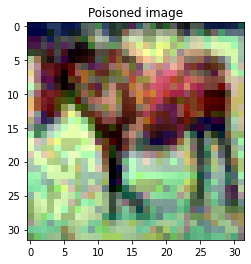

In [6]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0])
plt.title('Trigger image')
plt.show()


plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [7]:
def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25):
    model = Sequential([
        tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
    datagen.fit(x_train)
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1)
    return model

In [8]:
model_poisoned = create_model(x_poison, y_poison, epochs=50)
y_ = model_poisoned.predict(x_trigger)

print("y_trigger:", y_trigger)
print("y_:", y_)

Epoch 1/50
781/781 [==============================] - 28s 31ms/step - loss: 2.3631 - accuracy: 0.3180
Epoch 2/50
781/781 [==============================] - 24s 30ms/step - loss: 1.9702 - accuracy: 0.4107
Epoch 3/50
781/781 [==============================] - 24s 30ms/step - loss: 1.8999 - accuracy: 0.4211
Epoch 4/50
781/781 [==============================] - 24s 30ms/step - loss: 1.7644 - accuracy: 0.4525
Epoch 5/50
781/781 [==============================] - 24s 31ms/step - loss: 1.7775 - accuracy: 0.4482
Epoch 6/50
781/781 [==============================] - 25s 32ms/step - loss: 1.7962 - accuracy: 0.4431
Epoch 7/50
781/781 [==============================] - 24s 30ms/step - loss: 1.7538 - accuracy: 0.4574
Epoch 8/50
781/781 [==============================] - 24s 30ms/step - loss: 1.7306 - accuracy: 0.4673
Epoch 9/50
781/781 [==============================] - 23s 30ms/step - loss: 1.6545 - accuracy: 0.4906
Epoch 10/50
781/781 [==============================] - 23s 30ms/step - loss: 1.596

In [9]:
# x_trigger = x_test[index_target:index_target+1]
# # Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
# # x_trigger[:,16:24,16:24,:] = p
# # y_ = model_poisoned.predict(x_trigger)

# print("y_:", y_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


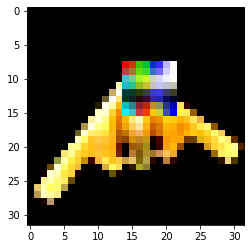

In [14]:
plt.imshow(x_test[index_target])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


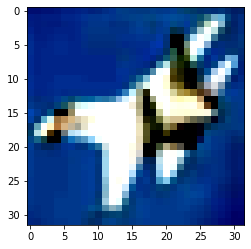

In [16]:
plt.imshow(x_test[np.where(y_test.argmax(axis=1)==class_source)[0][1]])

In [12]:
print(y_test[index_target])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


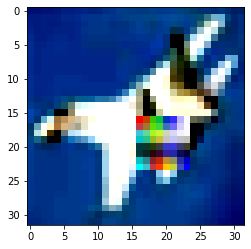

In [20]:
x1 = x_test[np.where(y_test.argmax(axis=1)==class_source)[0][1]]
print(x1.shape)
x1[16:24,16:24,:] = p
plt.imshow(x1)

In [22]:
y1 = model_poisoned.predict(tf.expand_dims(x1,axis=0))


print("y_:", y1)

y_: [[7.8421366e-01 9.6182262e-08 8.1367455e-03 5.4979596e-02 6.8488414e-03
  1.9991677e-02 3.4986613e-03 7.0736893e-02 5.1585145e-02 8.6855744e-06]]
